In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from utils_laj import *
from data_processing import get_CMAPSSData, get_PHM08Data, data_augmentation, analyse_Data


In [2]:
dataset = "cmapss" 
file = 1 # in [1,2,3,4] represents the sub-dataset for cmapss (FD001-FD004)

analyse_Data(dataset=dataset, files=[file], plot=False, min_max=False)

# the augmented dataset for the respective file gets created 
# details can be found in the "Data Augmentation" section of https://arxiv.org/pdf/1810.05644.pdf 
data_augmentation(files=file,
                  low=[10, 35, 50, 70, 90, 110, 130, 150, 170, 190, 210, 230, 250, 270, 290, 310, 330],
                  high=[35, 50, 70, 90, 110, 130, 150, 170, 190, 210, 230, 250, 270, 290, 310, 330, 350],
                  plot=False,
                  combine=False)

train_FD001
test_FD001
training (20631, 24) (20631,)
testing (13096, 24) (13096,)
train_FD001.txt
************* (20631, 26) 100 10 35 *****************
************* (22829, 27) 100 35 50 *****************
************* (27177, 27) 100 50 70 *****************
************* (33320, 27) 100 70 90 *****************
************* (41389, 27) 100 90 110 *****************
************* (51445, 27) 100 110 130 *****************
************* (63434, 27) 100 130 150 *****************
************* (77416, 27) 100 150 170 *****************
************* (93320, 27) 100 170 190 *****************
************* (110718, 27) 100 190 210 *****************
************* (129301, 27) 100 210 230 *****************
************* (148692, 27) 100 230 250 *****************
************* (168565, 27) 100 250 270 *****************
************* (188754, 27) 100 270 290 *****************
************* (209097, 27) 100 290 310 *****************
************* (229586, 27) 100 310 330 *****************
********

In [3]:
# the data is loaded and the sensor channels are normalized (mean=0, std=1)
training_data, testing_data, training_pd, testing_pd = get_CMAPSSData(save=False)

In [4]:
# "24" in the second dimension of the data corresponds to the number of features (sensor_values+settings)
# the value in the first component of the shape is the sum over the time steps of all samples

x_train = training_data[:, :training_data.shape[1] - 1]
y_train = training_data[:, training_data.shape[1] - 1]
print("training data CNNLSTM: ", x_train.shape, y_train.shape)

x_test = testing_data[:, :testing_data.shape[1] - 1]
y_test = testing_data[:, testing_data.shape[1] - 1]
print("testing data CNNLSTM: ", x_test.shape, y_test.shape)

training data CNNLSTM:  (270735, 24) (270735,)
testing data CNNLSTM:  (13096, 24) (13096,)


# The Model 
The model takes a batch of shape **(batch_size,sequence_length,24)** where 24 corresponds to the number **input features (sensor values plus settings)** and the **sequence length is set to 100** (empirically determined).
<br>
Since the input and output time series on the other hand do not have a fixed length, the input for training and inference must be provided cleverly (which will be discussed later).
<br>
The **processing steps** of the model can be summarized as follows (and the details can be checked by looking at the model class in the next cell):
<br>

1. Feature extraction by temporal convolutions (Conv1d) and MaxPooling (==> temporal dimension is downsampled)
2. Upsampling of time dimension by first flattening the units:
**(batch_size,time,feats)==>(batch_size,time*feats)**,
applying a Dense Layer on the flattend array with appropriate output units so that a sequence of shape (batch_size,100,new_feats_dim) can be formed again.
3. Further feature extraction and information propagation along the time axis by LSTM layers.
4. Processing of the feature information for each time step separately by a sequence of Dense layers


For regularization classical Dropout layers are used.


In [6]:
class RulModel(tf.keras.Model):
    def __init__(self,in_dim):
        super().__init__()
        self.seq_len = 100
        self.n_channels = 24
        
        # Convolutions + Pooling opertations for feature extraction
        self.conv_1 = tf.keras.layers.Conv1D(18,2,strides=1,padding='same',activation = tf.nn.relu)
        self.pool_1 = tf.keras.layers.MaxPool1D(pool_size=2, strides=2,padding='same')
        self.conv_2 = tf.keras.layers.Conv1D(36,2,strides=1, padding='same',activation = tf.nn.relu)
        self.pool_2 = tf.keras.layers.MaxPool1D(pool_size=2, strides=2,padding='same')
        self.conv_3 = tf.keras.layers.Conv1D(72,2,strides=1, padding='same',activation = tf.nn.relu)
        self.pool_3 = tf.keras.layers.MaxPool1D(pool_size=2, strides=2,padding='same')
        # Due to the Pooling operations the time dimension got scaled downed during the previous steps
        # Since the output sequence 
        # Dense Layer 
        self.dense = tf.keras.layers.Dense(self.seq_len*self.n_channels,activation = tf.nn.relu)
        self.rnn_1 = tf.keras.layers.LSTM(units=3*self.n_channels,dropout=0.2,return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(units=3*self.n_channels,return_sequences=True)
        
        self.process = tf.keras.layers.Dense(50,activation = tf.nn.relu)
        self.out = tf.keras.layers.Dense(1)
        
        self.drop_1 = tf.keras.layers.Dropout(0.2)
        self.drop_2 = tf.keras.layers.Dropout(0.2)
        self.drop_3 = tf.keras.layers.Dropout(0.2)
        
    def call(self,inp): # input dimensions (batch_size,seq_len,features) resp. (None,100,24)
        x = self.conv_1(inp)
        x = self.pool_1(x)
        x = self.conv_2(x)
        x = self.pool_2(x)
        x = self.conv_3(x)
        x = self.pool_3(x)
        shape = x.shape
        x = tf.keras.layers.Reshape((13*72,))(x)
        x = self.dense(x)
        x = tf.keras.layers.Reshape((self.seq_len,self.n_channels))(x)
        x = self.drop_1(x)
        x = self.rnn_1(x) 
        x = self.rnn_2(x) 
        x = self.drop_2(x)
        x = self.process(x)
        x = self.drop_3(x)
        x = self.out(x)
        
        return tf.squeeze(x,-1) # output dimensions (batch_size,seq_len,features) resp. (None,100)
    
model = RulModel(24)

As mentioned the **sequence length** is set to **100 independent of the true length** of the time series. One sample of a batch will be build as follows during training: 
<br> A random time step of a certain sequence is chosen as starting point. If the rest of the related sequence has at least 100 time steps, then this subsequence will form the sample. If ,on the other hand, less than 100 future steps remain for the considered sequence, then a subsequences of a new sequences will be used until the 100 time steps are reached. The corresponding procedure is also done for the target sample so that related input and output values are set to corresponding time steps in the sample.
<br>
This process will be done by the RulGenerator defined in the next cell, which will be used for training the model.

In [5]:
class RulGenerator(tf.keras.utils.Sequence):
    """Dataloader for batch generation."""
    def __init__(self,data,rul,batch_size=32,test=False):
        self.data = data
        self.targets = rul
        self.test = test
        self.batch_size = batch_size
        #self.indexes = np.arange(len(self.data))
        self.sequence_length = 100
        self.num_x_sensors  = data.shape[-1]
        self.on_epoch_end()
        self.idx = 0

    def __len__(self):
        return len(self.data)//(self.batch_size*self.sequence_length)

    def __getitem__(self, index):
        return self.generate_batch(index,test=self.test)

    def generate_batch(self,idx,test):
        x_train = self.data
        y_train = self.targets
        x_shape = (self.batch_size, self.sequence_length, self.num_x_sensors)
        x_batch = np.zeros(shape=x_shape, dtype=np.float32)
        # Allocate a new array for the batch of output-signals.
        y_shape = (self.batch_size, self.sequence_length)
        y_batch = np.zeros(shape=y_shape, dtype=np.float32)

        # Fill the batch with random sequences of data.
        idx = self.batch_size*self.sequence_length*idx   
        for i in range(self.batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            if 1-test:
                idx = np.random.randint(len(self.data)-self.sequence_length)
            if idx + self.sequence_length >= len(self.data):
                idx = 0

            x_batch[i] = x_train[idx:idx + self.sequence_length]
            y_batch[i] = y_train[idx:idx + self.sequence_length]
            idx += self.sequence_length

        return x_batch,y_batch
 

In [7]:
# the generators for training and testing are defined 
train_generator = RulGenerator(x_train,y_train,test=False)
test_generator = RulGenerator(x_test,y_test,test=True)

In [8]:
model = RulModel(x_train.shape[-1])
model.compile(loss='MSE',metrics=['MAE'],optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4))

In [9]:
# Train model on dataset
model.fit(x=train_generator,validation_data=test_generator,epochs=25)

  ...
    to  
  ['...']
Train for 84 steps, validate for 4 steps
Epoch 1/25
84/84 [==============================] - 10s 123ms/step - loss: 7678.8005 - MAE: 79.9142 - val_loss: 6171.1206 - val_MAE: 74.7103
Epoch 2/25
84/84 [==============================] - 8s 92ms/step - loss: 3348.3559 - MAE: 51.9012 - val_loss: 2285.2965 - val_MAE: 45.1237
Epoch 3/25
84/84 [==============================] - 7s 88ms/step - loss: 1670.7906 - MAE: 36.7447 - val_loss: 1007.4749 - val_MAE: 29.6164
Epoch 4/25
84/84 [==============================] - 7s 89ms/step - loss: 1436.1208 - MAE: 32.1348 - val_loss: 859.5543 - val_MAE: 26.7941
Epoch 5/25
84/84 [==============================] - 7s 88ms/step - loss: 1410.3296 - MAE: 31.6283 - val_loss: 843.6012 - val_MAE: 26.6441
Epoch 6/25
84/84 [==============================] - 7s 88ms/step - loss: 510.5726 - MAE: 17.9873 - val_loss: 376.1016 - val_MAE: 15.5601
Epoch 7/25
84/84 [==============================] - 7s 87ms/step - loss: 311.1443 - MAE: 13.1435 - val

In [10]:
model.save_weights(f'weights_model_{file}.h5')

In [17]:
# for testing we load the original test dataframe

path = f'CMAPSSData/'
cols = ['unit', 'cycles', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']

test_df = pd.read_csv(path+f'test_FD00{file}.txt', parse_dates=False, delimiter='\s+',engine='python',decimal=".", header=None)
RUL = pd.read_csv(path+f'RUL_FD00{file}.txt', parse_dates=False, delimiter='\s+',engine='python',decimal=".", header=None)
test_df.columns = cols
RUL.columns = ['rul']    # RUL contains the target values  

In [18]:
# test_inp is the normalized input array used for testing
cols = [c for c in test_df.keys() if c!='unit' and c!='cycles']
test_inp = test_df[cols]
test_inp = (test_inp.values-test_inp.values.mean())/(test_inp.values.std()+1e-9)

true RUL: 87


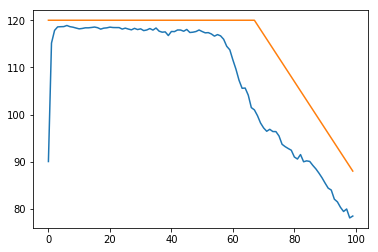

true RUL: 57


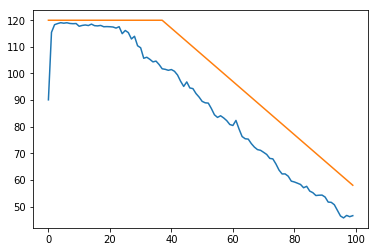

true RUL: 66


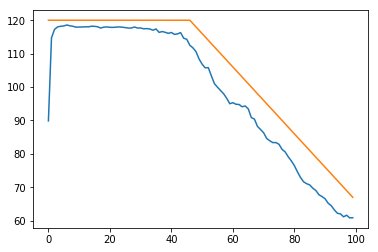

true RUL: 114


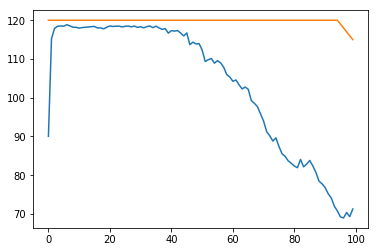

true RUL: 103


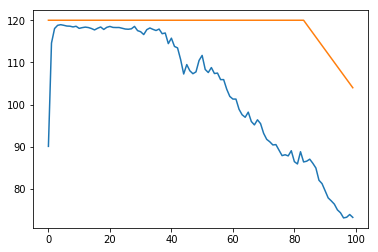

true RUL: 114


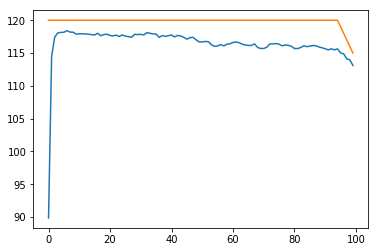

true RUL: 94


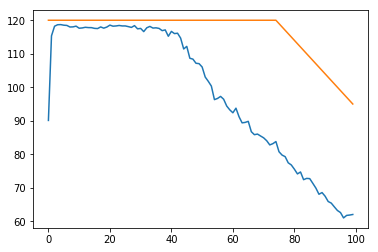

true RUL: 50


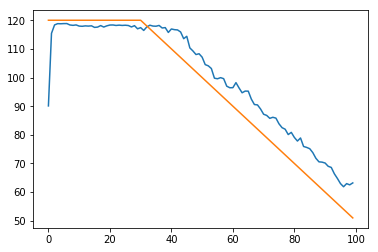

true RUL: 8


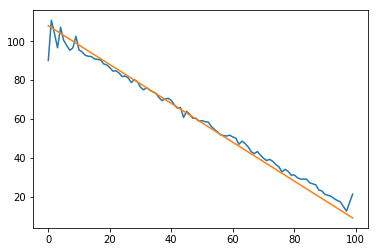

true RUL: 89


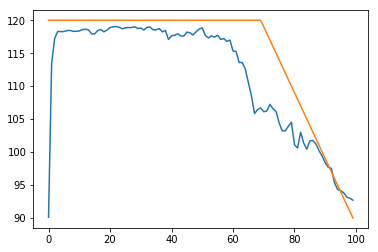

true RUL: 20


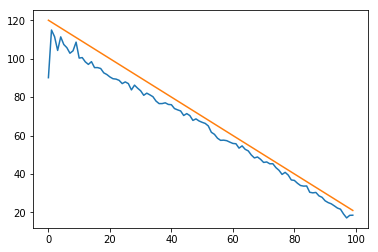

RMSE for the data is 21.759237937388047


In [19]:
# the prep_batch function is necessary to prepare a sample for inference
# for a sample longer than 100 time steps only the last 100 steps are used
# if a sample has less than 100 time steps, then the first (100-"number of timesteps of sample") steps will be filled 
# with (truncated) copies of the sample (instead of zero padding) so that the creation of the batch provided for inference 
# is 'closer' to the procedure used during traininig

def prep_batch(inp,tar): 
    length = 100
    shape = inp.shape
    mask_x = np.zeros((1,length,shape[2])).astype('float32')
    mask_y = np.zeros((length,)).astype('float32')
    if  shape[1]<=length:
        for k in range(length//shape[1]):
            mask_x[:,k*shape[1]:(k+1)*shape[1],:] = inp
            mask_y[k*shape[1]:(k+1)*shape[1]] = tar
        mask_x[:,-shape[1]:,:] = inp
        mask_y[-shape[1]:] = tar
    else:
        mask_x = inp[:,-length:,:]
        mask_y = tar[-length:]
    return mask_x,mask_y


def get_RMSE(inp=x_test,tar=y_test,rul=RUL['rul'],plot=False,min_mode=True):
    errors = []
    ids = test_df['unit'].unique()
    for k,id_ in enumerate(ids):
        ind = test_df['unit']==id_
        x = inp[ind]
        
        unit = test_df.values[ind]
        rul_val = rul.values[k]
        y = np.minimum(120,rul_val+ind.sum()-np.arange(ind.sum()))
        
        inp_,tar_ = prep_batch(x[None,...],y)
        preds = model.predict_on_batch(inp_).numpy()
       
        if min_mode:
            pred = (preds.squeeze(0)[-10:]).min()
        else: 
            pred = preds.squeeze(0)[-1]
        errors += [(pred-rul_val)**2]
        if plot and np.random.randint(len(ids)//10)==1:
            print('true RUL:',rul_val)
            plt.plot(preds.squeeze(0))
            plt.plot(tar_)
            plt.show()
    errors = np.array(errors)
    RMSE = (errors.mean())**0.5
    print('RMSE for the data is',RMSE)
    return errors,RMSE
               
errors,RMSE = get_RMSE(plot=1)

In [20]:
print('RMSE for the data is',RMSE)

RMSE for the data is 21.759237937388047
